# CSE 291 Assignment 2 BiLSTM CRF

## Download Data/Eval Script

In [1]:
!wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
!wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/train.data.quad
!wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/dev.data.quad

--2021-05-30 05:08:28--  https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7502 (7.3K) [text/plain]
Saving to: ‘conlleval.py’

conlleval.py        100%[===================>]   7.33K  --.-KB/s    in 0s      

2021-05-30 05:08:29 (102 MB/s) - ‘conlleval.py’ saved [7502/7502]

--2021-05-30 05:08:29--  https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/train.data.quad
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 745734 (728K) [text/plain]
Sa

In [2]:
import conlleval
from tqdm import tqdm
import numpy as np
from collections import defaultdict, Counter
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

torch.manual_seed(291)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Data Preparation

In [3]:
TRAIN_DATA = 'train.data.quad'
VALID_DATA = 'dev.data.quad'
UNK = '<unk>'
PAD = '<pad>'
START_TAG = "<start>"  # you can add this explicitly or use it implicitly in your CRF layer
STOP_TAG = "<stop>"    # you can add this explicitly or use it implicitly in your CRF layer


def read_conll_sentence(path):
    """ Read a CONLL-format sentence into vocab objects
    Args:
        :param path: path to CONLL-format data file
        :param word_vocab: Vocabulary object for source
        :param label_vocab: Vocabulary object for target
    """
    sent = [[], []]
    with open(path) as f:
        for line in f:
            line = line.strip().split()
            if line:
                # replace numbers with 0000
                word = line[0]
                word = '0000' if word.isnumeric() else word
                sent[0].append(word)
                sent[1].append(line[3])
            else:
                yield sent[0], sent[1]
                sent = [[], []]


def prepare_dataset(dataset, word_vocab, label_vocab):
    dataset = [
      [
        torch.tensor([word_vocab.stoi[word] for word in sent[0]], dtype=torch.long),
        torch.tensor([label_vocab.stoi[label] for label in sent[1]], dtype=torch.long),
      ]
      for sent in dataset
    ]
    return dataset


# load a list of sentences, where each word in the list is a tuple containing the word and the label
train_data = list(read_conll_sentence(TRAIN_DATA))
train_word_counter = Counter([word for sent in train_data for word in sent[0]])
train_label_counter = Counter([label for sent in train_data for label in sent[1]])
word_vocab = Vocab(train_word_counter, specials=(UNK, PAD), min_freq=2)
label_vocab = Vocab(train_label_counter, specials=(), min_freq=1)
train_data = prepare_dataset(train_data, word_vocab, label_vocab)
d={START_TAG:8,STOP_TAG:9}
label_vocab.stoi.update(d)
print(label_vocab.stoi[START_TAG])
print('Train word vocab:', len(word_vocab), 'symbols.')
print('Train label vocab:', len(label_vocab), f'symbols: {list(label_vocab.stoi.keys())}')
valid_data = list(read_conll_sentence(VALID_DATA))
valid_data = prepare_dataset(valid_data, word_vocab, label_vocab)
print('Train data:', len(train_data), 'sentences.')
print('Valid data:', len(valid_data))

print(' '.join([word_vocab.itos[i.item()] for i in train_data[0][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in train_data[0][1]]))

print(' '.join([word_vocab.itos[i.item()] for i in valid_data[1][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in valid_data[1][1]]))

8
Train word vocab: 3947 symbols.
Train label vocab: 8 symbols: ['O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC', '<start>', '<stop>']
Train data: 3420 sentences.
Valid data: 800
Pusan 0000 0000 0000 0000 0000 0000
I-ORG O O O O O O
Earlier this month , <unk> denied a Kabul government statement that the two sides had agreed to a ceasefire in the north .
O O O O I-PER O O I-LOC O O O O O O O O O O O O O O O


In [4]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

## BiLSTMTagger

In [5]:
# Starter code implementing a BiLSTM Tagger
# which makes locally normalized, independent
# tag classifications at each time step

class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, dropout=0.3):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix.keys())
        #self.tagset_size = tag_vocab_size
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True).to(device)
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size).to(device)
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size))
        self.dropout = nn.Dropout(p=dropout)
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))
    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas.to(device)

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.dropout(self.word_embeds(sentence))
        #embeds=embeds[0]
        
        #embeds=embeds.view(-1, self.tagset_size)
        #hidden.view(-1, self.tagset_size)
        #print(f"embeds: {embeds}\n word embeds: {self.word_embeds(sentence)}\n self.hidden {self.hidden}")
        bilstm_out, hidden = self.bilstm(embeds, self.hidden)

        bilstm_out = self.dropout(bilstm_out)
        bilstm_out = bilstm_out
        bilstm_feats = self.hidden2tag(bilstm_out)
        return bilstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        cuda0=torch.device('cuda:0')
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long,device=cuda0), tags[0]])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars.to(device)
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence).view(-1, self.tagset_size).to(device)
        forward_score = self._forward_alg(feats).to(device)
        gold_score = self._score_sentence(feats, tags).to(device)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        bilstm_feats = self._get_lstm_features(sentence).view(-1,self.tagset_size)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(bilstm_feats)
        return score, tag_seq
    def loss(self, sentence, tags):##starter_modified
        #bilstm_feats = self.compute_lstm_emission_features(sentence)
        r= self.neg_log_likelihood(sentence, tags)
        # transform predictions to (n_examples, n_classes) and ground truth to (n_examples)
        return r[0] #########################
'''def compute_lstm_emission_features(self, sentence):##starter
        hidden = self.init_hidden()
        embeds = self.dropout(self.word_embeds(sentence))
        #print(f"embeds: {embeds}\n word embeds: {self.word_embeds(sentence)}\n self.hidden {hidden}")
        bilstm_out, hidden = self.bilstm(embeds, hidden)
        bilstm_out = self.dropout(bilstm_out)
        bilstm_out = bilstm_out
        bilstm_feats = self.tag_projection_layer(bilstm_out)
        return bilstm_feats
def forward(self, sentence):##starter_has copy
        bilstm_feats = self.compute_lstm_emission_features(sentence)
        return bilstm_feats.max(-1)[0].sum(), bilstm_feats.argmax(-1)'''
    #


'def compute_lstm_emission_features(self, sentence):##starter\n        hidden = self.init_hidden()\n        embeds = self.dropout(self.word_embeds(sentence))\n        #print(f"embeds: {embeds}\n word embeds: {self.word_embeds(sentence)}\n self.hidden {hidden}")\n        bilstm_out, hidden = self.bilstm(embeds, hidden)\n        bilstm_out = self.dropout(bilstm_out)\n        bilstm_out = bilstm_out\n        bilstm_feats = self.tag_projection_layer(bilstm_out)\n        return bilstm_feats\ndef forward(self, sentence):##starter_has copy\n        bilstm_feats = self.compute_lstm_emission_features(sentence)\n        return bilstm_feats.max(-1)[0].sum(), bilstm_feats.argmax(-1)'

## Train / Eval loop

In [6]:
def train(model, train_data, valid_data, word_vocab, label_vocab, epochs, log_interval=25):
    losses_per_epoch = []
    F1_scores=[]
    lossavg=[]
    valid_loss=[]
    for epoch in range(epochs):
        print(f'--- EPOCH {epoch} ---')
        model.train()
        losses_per_epoch.append([])
        for i, (sent, tags) in enumerate(train_data):
            model.zero_grad()
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            loss = model.loss(sent, tags)
            loss.backward()
            optimizer.step()

            losses_per_epoch[-1].append(loss.detach().cpu().item())
            if i > 0 and i % log_interval == 0:
                print(f'Avg loss over last {log_interval} updates: {np.mean(losses_per_epoch[-1][-log_interval:])}')

        k, li=evaluate(model, valid_data, word_vocab, label_vocab)
        F1_scores.append(k)
        print(F1_scores)
        sum=0
        for i in losses_per_epoch[-1]:
            sum+=i
        sum=sum/len(losses_per_epoch[-1])
        lossavg.append(sum)
        print(lossavg)
        valid_loss.append(li)
    return F1_scores, lossavg, valid_loss


def evaluate(model, dataset, word_vocab, label_vocab):
    model.eval()
    losses = []
    scores = []
    true_tags = []
    pred_tags = []
    sents = []
    for i, (sent, tags) in enumerate(dataset):
        with torch.no_grad():
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            
            losses.append(model.loss(sent, tags).cpu().detach().item())
            score, pred_tag_seq = model(sent)
            scores.append(score.cpu().detach().numpy())
            true_tags.append([label_vocab.itos[i] for i in tags.tolist()[0]])
            #print(pred_tag_seq)
            pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq])
            sents.append([word_vocab.itos[i] for i in sent[0]])

    print('Avg evaluation loss:', np.mean(losses))
    F1=conlleval.evaluate([tag for tags in true_tags for tag in tags], [tag for tags in pred_tags for tag in tags], verbose=True)
    print(F1)
    print('\n5 random evaluation samples:')
    for i in np.random.randint(0, len(sents), size=5):
        print('SENT:', ' '.join(sents[i]))
        print('TRUE:', ' '.join(true_tags[i]))
        print('PRED:', ' '.join(pred_tags[i]))
    return F1[2], np.mean(losses)


## Training

In [12]:
# Train BiLSTM Tagger Baseline
model = BiLSTM_CRF(len(word_vocab), label_vocab.stoi, 128, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
F1_scores, losses, l=train(model, train_data, valid_data, word_vocab, label_vocab, epochs=20, log_interval=500)


--- EPOCH 0 ---
Avg loss over last 500 updates: 10.640667314529418
Avg loss over last 500 updates: 8.562806468963624
Avg loss over last 500 updates: 6.6640385255813595
Avg loss over last 500 updates: 5.836283703804016
Avg loss over last 500 updates: 4.939681134223938
Avg loss over last 500 updates: 4.945787421226502
Avg evaluation loss: 4.526355362534523
processed 11170 tokens with 1231 phrases; found: 731 phrases; correct: 452.
accuracy:  44.11%; (non-O)
accuracy:  88.74%; precision:  61.83%; recall:  36.72%; FB1:  46.08
              LOC: precision:  77.53%; recall:  38.02%; FB1:  51.02  178
             MISC: precision:  68.57%; recall:  12.50%; FB1:  21.15  35
              ORG: precision:  62.23%; recall:  38.11%; FB1:  47.27  188
              PER: precision:  52.42%; recall:  46.88%; FB1:  49.50  330
(61.83310533515732, 36.718115353371246, 46.07543323139653)

5 random evaluation samples:
SENT: CALIFORNIA 0000 0000 <unk> 0000
TRUE: I-ORG O O O O
PRED: I-ORG O O I-ORG O
SENT: Aust

In [13]:
print(F1_scores)
print(losses)
print(l)

[46.07543323139653, 58.994833255049315, 65.75591985428049, 66.4565511031067, 69.3498452012384, 68.6842105263158, 70.66025360734587, 72.5841714035855, 72.08695652173913, 71.35593220338983, 72.6261762189906, 72.40484429065742, 72.59574468085106, 72.64957264957265, 73.11827956989248, 72.91930713983945, 72.00660611065234, 73.44345616264295, 73.04274227676683, 73.50210970464134]
[6.6432928626997425, 3.624143900020778, 2.5993108559770195, 2.0674385428080084, 1.7451094610997808, 1.4974315601482726, 1.346749971205728, 1.1971876372370804, 1.1051560028254637, 0.9938622546823401, 0.9214869599593313, 0.8922975646473511, 0.8214971598477392, 0.7831100260305126, 0.7325638329773618, 0.6775784674443697, 0.6774572501057072, 0.6412561730334633, 0.603243356977987, 0.5534306035404317]
[4.526355362534523, 3.409770675301552, 2.974259833395481, 2.811852522492409, 2.7391921460628508, 2.7203063863515853, 2.727693136036396, 2.7438551032543184, 2.7880976888537408, 2.8332940067350862, 3.0228522665798665, 3.1685681

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] [6.6432928626997425, 3.624143900020778, 2.5993108559770195, 2.0674385428080084, 1.7451094610997808, 1.4974315601482726, 1.346749971205728, 1.1971876372370804, 1.1051560028254637, 0.9938622546823401, 0.9214869599593313, 0.8922975646473511, 0.8214971598477392, 0.7831100260305126, 0.7325638329773618, 0.6775784674443697, 0.6774572501057072, 0.6412561730334633, 0.603243356977987, 0.5534306035404317]


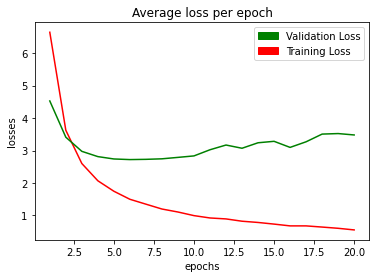

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] [46.07543323139653, 58.994833255049315, 65.75591985428049, 66.4565511031067, 69.3498452012384, 68.6842105263158, 70.66025360734587, 72.5841714035855, 72.08695652173913, 71.35593220338983, 72.6261762189906, 72.40484429065742, 72.59574468085106, 72.64957264957265, 73.11827956989248, 72.91930713983945, 72.00660611065234, 73.44345616264295, 73.04274227676683, 73.50210970464134]


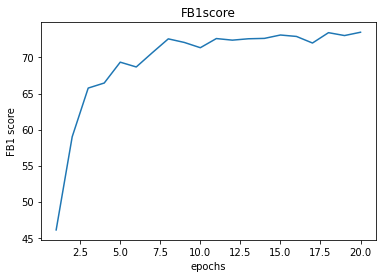

In [14]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
x, y=[], []
count=0 
# x axis values
for i in (losses):
    count+=1
    y.append(count)
    x.append(i)
print(y,x)

  
# plotting the points 
plt.plot(y,x, color='red')
plt.plot(y,l, color='green')
  
# naming the x axis
plt.xlabel('epochs')
# naming the y axis
plt.ylabel('losses')
  
# giving a title to my graph
plt.title("Average loss per epoch")
red_patch = mpatches.Patch(color='red', label='Training Loss')

g_patch = mpatches.Patch(color='green', label='Validation Loss')
plt.legend(handles=[g_patch, red_patch])
# function to show the plot
plt.show()
#-----------------------------------------------------------------------
x, y=[], []
count=0 
# x axis values
for i in (F1_scores):
    count+=1
    y.append(count)
    x.append(i)
print(y,x)

  
# plotting the points 
plt.plot(y,x)
  
# naming the x axis
plt.xlabel('epochs')
# naming the y axis
plt.ylabel('FB1 score')
  
# giving a title to my graph
plt.title("FB1score")
  
# function to show the plot
plt.show()
